In [ ]:
# This script will plot and examine some of the results from BB2017;
# 3 tasks to do
# First, check evolution of the Paluch mixing diagram
# Second, compute two aggregation metric and see how consistent they are in describing self-aggregation
# Third, check the wind structure (mesoscale circulation)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os 

In [2]:
from matplotlib import animation
import seaborn as sbn    # not available in the environment yet.

In [3]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
#%matplotlib inline

In [4]:
%matplotlib inline

In [5]:
# specify the data path:
datadir = '/data/xchen/BB2017'

In [6]:
# Task #3: check the wind structure and mesoscale circulation.
folder1 = 'OUT_2D'
folder2 = 'OUT_3D'    # 
folder3 = 'OUT_STAT'  # time-varying, horizontally-averaged profiles of domain-mean quantities

filename_stat = 'S6_CTL_512sqx128_250m_testf.nc'
filename_3D = 'S6_CTL_MSE_512sqx128_250m_testf_0128_CONCAT.nc'

file_prefix = 'S6_CTL_512sqx128_250m_testf'


In [94]:
# establish a dictionary for the filename:
filenames=dict()
filenames['cntrl']=file_prefix + '.nc'
filenames['RFhomoNoPCP']=file_prefix + '_RADFLXhomo_noPCP.nc'
filenames['RADFLXhomo']=file_prefix + '_RADFLXhomo.nc'
filenames['RADhomo'] = file_prefix + '_RADhomo.nc'
filenames['WTG'] = file_prefix + '_WTG.nc'

In [8]:
absfn = os.path.join(datadir, folder3, filename_stat)
ds_stat = xr.open_dataset(absfn)

# absfn_3D = os.path.join(datadir, folder2, filename_3D)
# ds_eD = xr.open_dataset(absfn_3D)

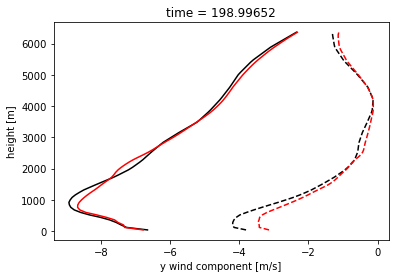

In [21]:
# how does the domain mean wind evolve in the control case?
# how does the domain mean thermodynamic profiles evovle in the control case?

# this is the domain mean wind:
ds_stat.U[0,0:80].plot(y='z',color='k',linestyle='-')
ds_stat.V[0,0:80].plot(y='z',color='k',linestyle='--')


ds_stat.U[-1,0:80].plot(y='z',color='r',linestyle='-')
ds_stat.V[-1,0:80].plot(y='z',color='r',linestyle='--')




In [22]:
# domain mean thermodynamci:
#ds_stat.time[-1]-ds_stat.time[0]
#ds_stat.ZINV[0]


# compute the virtual liquid static energy:
# note that Lv and Cp is set to the same value as used in the SAM model.
Lv = 2.5104*10**6
mu = 0.93
Cp = 1003.5
ds_stat['Svl'] = ds_stat.MSE - mu*Lv*(ds_stat.QT/1000)/Cp


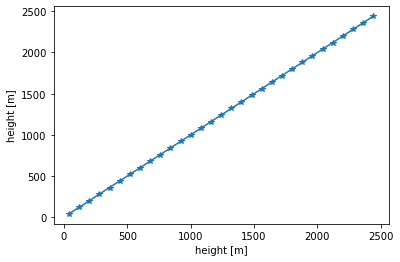

In [22]:

ds_stat.z.where(ds_stat.z<2500,drop=True).plot(marker='*')

In [10]:
@widgets.interact(i=(0,len(ds_stat.ZINV),10))
def test(i=10):
    dz=ds_stat.z-ds_stat.ZINV[i]*1000
    test=ds_stat.where(abs(ds_stat.z-ds_stat.ZINV[i]*1000)==np.min(abs(dz)), drop=True)
    print(ds_stat.ZINV[i].values*1000)
    print(test.z[-1].values)
    plt.plot(ds_stat.time, ds_stat.ZINV*1000)
    #plt.plot(ds_stat.time[1]*np.ones(len(ds_stat.z)), ds_stat.z,marker='.')
    plt.plot(ds_stat.time[i],test.z[-1],marker='*')
    plt.show()



interactive(children=(IntSlider(value=10, description='i', max=432, step=10), Output()), _dom_classes=('widget…

In [40]:
# Test work around # 1:
z_trunc=[None]*len(ds_stat.ZINV)
for i in range(len(ds_stat.ZINV)):
    dz=ds_stat.z-ds_stat.ZINV[i]*1000
    test= np.where(abs(dz)==np.min(abs(dz)))   
    z_trunc[i]=ds_stat.z[test].values
#     print(ds_stat.ZINV[i].values*1000)
#     print(test.z[-1].values)


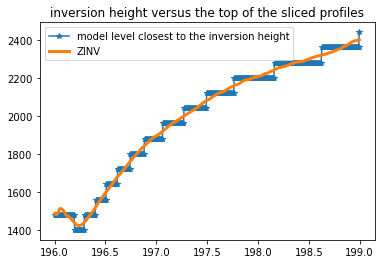

In [45]:
#plt.plot(ds_stat.time[1]*np.ones(len(ds_stat.z)), ds_stat.z,marker='.')
plt.plot(ds_stat.time,z_trunc,marker='*')
plt.plot(ds_stat.time, ds_stat.ZINV*1000,linewidth=3)
plt.title('inversion height versus the top of the sliced profiles')
plt.legend(['model level closest to the inversion height','ZINV'])
plt.show()
plt.savefig()

work around #1 will still produce jumpiness because the discrete nature of the vertical levels in the LES model
The solution is to interpolate the LES vertical profiles of MSE and $S_{vl}$ to the exact inversion height which is a smooth curve. 

In [47]:
from scipy import interpolate

(0.0, 3000.0)

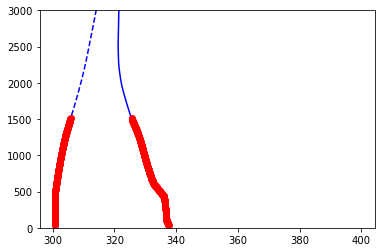

In [52]:
# Test work around #2:
i = 10
# work around #2: create a finer vertical levels from 0 to ZINV. 
z_fine= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, 300)
f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
MSE_subfine = f_MSE(z_fine)
Svl_subfine = f_Svl(z_fine)

# plot out interpolation result to confirm:
plt.plot(ds_stat.MSE[i,:], ds_stat.z, color='b')
plt.plot(MSE_subfine, z_fine, color='r', linestyle=None, marker='o')
plt.ylim(0,3000)

plt.plot(ds_stat.Svl[i,:], ds_stat.z, color='b',linestyle='--')
plt.plot(Svl_subfine, z_fine, color='r', linestyle='--', marker='o')
plt.ylim(0,3000)


In [87]:
# another thing to check is that: is the ZINV correspond to the real inversion height produced from the model?
it=200
@widgets.interact
def check_domain_mean_parms(it=200):
    fig01, axes = plt.subplots(2,2,figsize=(10,10))
    # thetaL: liquid water potential temperature
    axes[0,0].plot(ds_stat.THETAL[it,:], ds_stat.z)
    axes[0,0].plot([290, 320],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[0,0].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[0,0].set_xlim(290, 320)
    axes[0,0].set_title(ds_stat.THETAL.long_name)
    axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[0,0].set_xlabel('theta_l (K)')
    axes[0,0].grid(True)


    # qv: water vapor mixing ratio
    axes[0,1].plot(ds_stat.QV[it,:], ds_stat.z)
    axes[0,1].plot([0, 16],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[0,1].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[0,1].set_xlim(0, 16)
    axes[0,1].set_title(ds_stat.QV.long_name)
    #axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[0,1].set_xlabel('q_v (g/kg)')
    axes[0,1].grid(True)
    
    
    # U: zonal wind
    axes[1,0].plot(ds_stat.U[it,:], ds_stat.z)
    axes[1,0].plot(ds_stat.UOBS[it,:], ds_stat.z,linestyle='--',color='g')
    axes[1,0].plot([-15, 15],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[1,0].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[1,0].set_xlim(-15, 15)
    axes[1,0].set_title(ds_stat.U.long_name)
    #axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[1,0].set_xlabel('U (m/s)')
    axes[1,0].grid(True)
    axes[1,0].legend(['U','UOBS'])
    
    
    # V: zonal wind
    axes[1,1].plot(ds_stat.V[it,:], ds_stat.z)
    axes[1,1].plot(ds_stat.VOBS[it,:], ds_stat.z,linestyle='--',color='g')
    axes[1,1].plot([-15, 15],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[1,1].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[1,1].set_xlim(-15, 15)
    axes[1,1].set_title(ds_stat.V.long_name)
    #axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[1,1].set_xlabel('V (m/s)')
    axes[1,1].grid(True)
    axes[1,1].legend(['V','VOBS'])
    
    plt.show()


# wind field:


interactive(children=(IntSlider(value=200, description='it', max=600, min=-200), Output()), _dom_classes=('wid…

In [46]:
# domain mean thermodynamci:


In [53]:
def plot(i=10, grid=True):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    
    ds_sub = ds_stat.where(ds_stat.z<=ds_stat.ZINV[0]*1000, drop=True)
    # initial:
    ax.plot(ds_sub.Svl[0,:], ds_sub.MSE[0, :],color='b')
    ax.plot([ds_sub.Svl[0,0], ds_sub.Svl[0,-1]], [ds_sub.MSE[0,0], ds_sub.MSE[0,-1]],
           linestyle='--', color='b')
    
    # work around #2: create a finer vertical levels from 0 to ZINV. 
    z_fine= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, 300)
    f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
    f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
    MSE_subfine = f_MSE(z_fine)
    Svl_subfine = f_Svl(z_fine)

    
    ax.plot(Svl_subfine, MSE_subfine,color='r')
    ax.plot([Svl_subfine[0], Svl_subfine[-1]], [MSE_subfine[0], MSE_subfine[-1]],
           linestyle='--', color='r')
    dt = (ds_sub.time[i]-ds_sub.time[0])*24.0
    ax.set_title('time:' + "{:.2f}".format(dt.values) + 'th hr')
    ax.grid(grid)
    ax.set_ylim(320, 340)
    ax.set_xlim(290, 310)
    plt.show()
 


interactive(children=(IntSlider(value=10, description='i', max=432, step=6), Checkbox(value=True, description=…

<function __main__.plot(i=10, grid=True)>

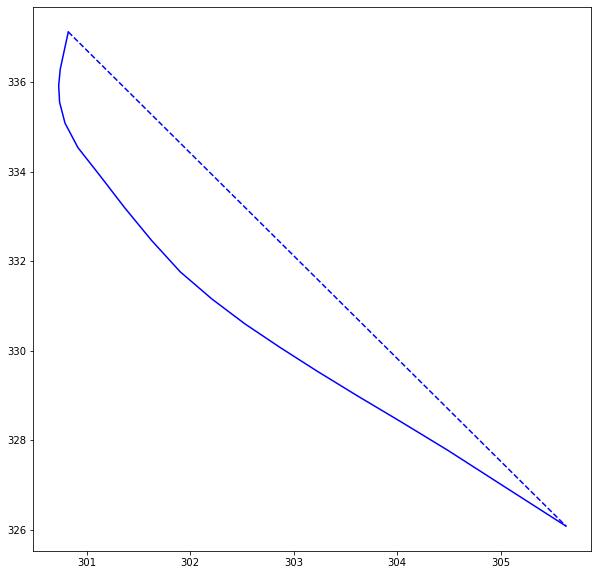

In [54]:
widgets.interact(plot, i=(0,len(ds_stat.ZINV),6))


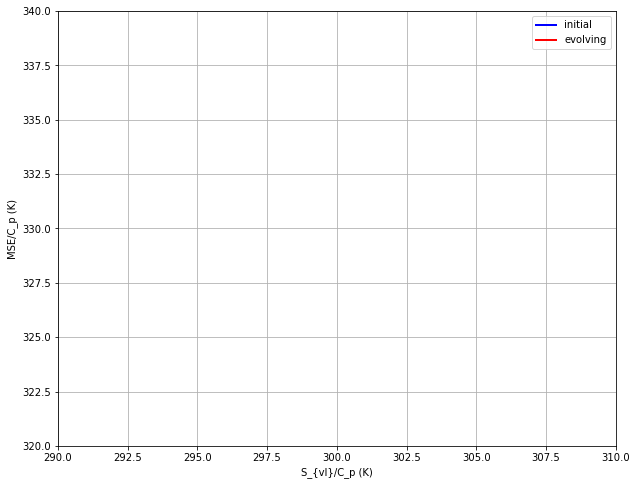

In [89]:
# now, let me try doing it in an animation:
from matplotlib import animation, rc
from IPython.display import HTML

# first set up the figure, the axis, and the plot element
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim((290,310))
ax.set_ylim((320,340))
line1,  = ax.plot([],[], lw =2,color='b')
line2, = ax.plot([],[], lw=2, color='r')
line3, = ax.plot([],[],linestyle='--', color='b')
line4, = ax.plot([],[],linestyle='--', color='r')
ax.set_xlabel('S_{vl}/C_p (K)')
ax.set_ylabel('MSE/C_p (K)')
titlestr = ax.set_title('')
ax.legend(['initial','evolving'])
ax.grid(True)



In [90]:
def init():
    line1.set_data([],[])
    line2.set_data([],[])
    line3.set_data([],[])
    line4.set_data([],[])
    return (line1, line2,line3, line4,  
             )

def animate(i):
    x = np.linspace(0,2,1000)
    y = np.sin(2*np.pi * (x-0.01*i))
    line.set_data(x,y)
    return (line,)


# I am going to re-edit this function here:
def animate_Paluch(i):
    #fig, ax = plt.subplots(1,1, figsize=(10,10))
    ds_sub = ds_stat.where(ds_stat.z<ds_stat.ZINV[0]*1000, drop=True)
    # initial:
    x0 = ds_sub.Svl[0,:]
    y0 = ds_sub.MSE[0, :]
    line1.set_data(x0, y0)
   

   # work around #2: create a finer vertical levels from 0 to ZINV. 
    z_fine= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, 300)
    f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
    f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
    yi = f_MSE(z_fine)
    xi = f_Svl(z_fine)
    
    line2.set_data(xi, yi)
    
    line3.set_data([x0[0], x0[-1]], [y0[0], y0[-1]])
    line4.set_data([xi[0], xi[-1]], [yi[0], yi[-1]])
    
    dt = (ds_sub.time[i]-ds_sub.time[0])*24.0
    titlestr.set_text('Time {1:d} = {0:.2f} th hour '.format(dt.values, i))
    
    #ax.plot(ds_sub2.Svl[i,:], ds_sub2.MSE[i, :],color='r')
    #ax.plot([ds_sub2.Svl[i,0], ds_sub2.Svl[i,-1]], [ds_sub2.MSE[i,0], ds_sub2.MSE[i,-1]],
#            linestyle='--', color='r')
     
#     ax.set_title('time:' + "{:.2f}".format(dt.values) + 'th hr')
#     ax.grid(grid)
#     ax.set_ylim(320, 340)
#     ax.set_xlim(290, 310)
   
    return(line1, line2, line3, line4,)
 




In [91]:
import matplotlib

anim = matplotlib.animation.FuncAnimation(fig, animate_Paluch, init_func=init, frames=range(len(ds_stat.time)), interval=100, blit=True)




In [92]:
HTML(anim.to_html5_video())

In [93]:
f = r"/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/control_MSE_Svl_Evolution.mp4" 
writervideo = animation.FFMpegWriter(fps=5) 
anim.save(f, writer=writervideo)

In [99]:
# check how correlated it is between the two metrics that is used to identify aggregation
np.diff(ds_sub.time[0:10])*3600*24

array([599.8535, 599.8535, 599.8535, 599.8535, 599.8535, 599.8535,
       599.8535, 599.8535, 601.1719], dtype=float32)

In [20]:
ds_eD.U[0,:,]


<xarray.Dataset>
Dimensions:   (time: 432, x: 32, y: 32, z: 128)
Coordinates:
  * x         (x) float32 0.0 4e+03 8e+03 1.2e+04 ... 1.16e+05 1.2e+05 1.24e+05
  * y         (y) float32 0.0 4e+03 8e+03 1.2e+04 ... 1.16e+05 1.2e+05 1.24e+05
  * z         (z) float32 40.0 120.0 200.0 ... 1.812e+04 1.884e+04 1.961e+04
  * time      (time) float32 196.0 196.0 196.0 196.0 ... 199.0 199.0 199.0 199.0
Data variables: (12/67)
    p         (z) float32 ...
    U         (time, z, y, x) float32 ...
    V         (time, z, y, x) float32 ...
    W         (time, z, y, x) float32 ...
    TABS      (time, z, y, x) float32 ...
    TVPRIME   (time, z, y, x) float32 ...
    ...        ...
    WSTOR     (time, z, y, x) float32 ...
    WEDDY     (time, z, y, x) float32 ...
    WLSF      (time, z, y, x) float32 ...
    WMISC     (time, z, y, x) float32 ...
    WPGRAD    (time, z, y, x) float32 ...
    WBUOY     (time, z, y, x) float32 ...
Attributes:
    history:                   Sat Jun 10 21:58:00 2017: ncrcat -o S6_CTL_MSE...
    nco_openmp_thread_number:  1

In [123]:
# test:
def plot2(m,c):
    x = np.random.rand(10)
    y = m *x + c
    plt.plot(x,y)
    plt.show()

In [58]:
ds_stat

<xarray.Dataset>
Dimensions:     (time: 432, z: 128)
Coordinates:
  * z           (z) float32 40.0 120.0 200.0 ... 1.812e+04 1.884e+04 1.961e+04
  * time        (time) float32 196.0 196.0 196.0 196.0 ... 199.0 199.0 199.0
Data variables: (12/559)
    p           (z) float32 1.009e+03 1e+03 991.2 982.2 ... 76.38 67.62 59.59
    SST         (time) float32 298.8 298.8 298.8 298.8 ... 298.8 298.8 298.8
    Ps          (time) float32 1.014e+03 1.014e+03 ... 1.014e+03 1.014e+03
    CLDSHD      (time) float32 0.0 0.0 0.0 0.0 ... 0.09236 0.09078 0.08695
    AREAPREC    (time) float32 0.0 0.0 0.0 0.0 ... 0.0306 0.02953 0.02936
    CLD245      (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    QVENV       (time, z) float32 15.61 15.28 15.13 ... 0.002307 0.002105
    QCENV       (time, z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    QTOENV      (time, z) float32 15.61 15.28 15.13 ... 0.002307 0.002105
    QRENV       (time, z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NRENV       (time, z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Svl         (time, z) float32 300.8 300.7 300.7 300.7 ... 379.5 389.5 399.4
Attributes:
    SAM version:  
    caseid:       512sqx128_250m_testf

In [ ]:
for i in range(len(ds_stat.ZINV)):
    ds_sub = ds_stat.where(ds_stat.z<ds_stat.ZINV[0]*1000, drop=True)
    fig,ax=plt.subplots(1,1,)
    ax.plot(ds_sub.DSE[0,:], ds_sub.MSE[0, :],color='b')
    ax.plot([ds_sub.DSE[0,0], ds_sub.DSE[0,-1]], [ds_sub.MSE[0,0], ds_sub.MSE[0,-1]],
           linestyle='--', color='b')

    ds_sub2 = ds_stat.where(ds_stat.z<ds_stat.ZINV[i]*1000, drop=True)
    ax.plot(ds_sub2.DSE[i,:], ds_sub2.MSE[i, :],color='r')
    ax.plot([ds_sub2.DSE[i,0], ds_sub2.DSE[i,-1]], [ds_sub2.MSE[i,0], ds_sub2.MSE[i,-1]],
           linestyle='--', color='r')
    